In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')
jayeshlandge_cremad_path = kagglehub.dataset_download('jayeshlandge/cremad')

print('Data source import complete.')


Data source import complete.


In [3]:
import shutil
import os

target_dir = "datasets"
os.makedirs(target_dir, exist_ok=True)

# Copy each dataset to target_dir
datasets = {
    "ravdess": uwrfkaggler_ravdess_emotional_speech_audio_path,
    "tess": ejlok1_toronto_emotional_speech_set_tess_path,
    "savee": ejlok1_surrey_audiovisual_expressed_emotion_savee_path,
    "cremad": jayeshlandge_cremad_path
}

for name, path in datasets.items():
    dest = os.path.join(target_dir, name)
    if not os.path.exists(dest):
        shutil.copytree(path, dest)
    print(f"{name} copied to {dest}")

print("All datasets stored")

ravdess copied to datasets\ravdess
tess copied to datasets\tess
savee copied to datasets\savee
cremad copied to datasets\cremad
All datasets stored


In [4]:
import pandas as pd
import numpy as np
import os
import sys
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Embedding, LSTM, BatchNormalization, GRU,
    Input, Flatten, Dropout, Activation,
    Conv1D, MaxPooling1D, AveragePooling1D
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Protobuf gencode version")
import tensorflow as tf
print ("Done")

C:\Users\SHIVA GANGADHAR\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\SHIVA GANGADHAR\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\SHIVA GANGADHAR\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.3

Done


In [9]:
ravdess = uwrfkaggler_ravdess_emotional_speech_audio_path + "/audio_speech_actors_01-24/"

ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [10]:
Crema = jayeshlandge_cremad_path + "/AudioWAV/"

# TESS
Tess = ejlok1_toronto_emotional_speech_set_tess_path + "/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"

# SAVEE
Savee = ejlok1_surrey_audiovisual_expressed_emotion_savee_path + "/ALL/"

In [11]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [12]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprised'},
                            inplace=True)
print(ravdess_df.head())

  Emotions                                               Path
0  neutral  C:\Users\SHIVA GANGADHAR\.cache\kagglehub\data...
1  neutral  C:\Users\SHIVA GANGADHAR\.cache\kagglehub\data...
2  neutral  C:\Users\SHIVA GANGADHAR\.cache\kagglehub\data...
3  neutral  C:\Users\SHIVA GANGADHAR\.cache\kagglehub\data...
4     calm  C:\Users\SHIVA GANGADHAR\.cache\kagglehub\data...


In [13]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

In [14]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprised')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
angry        400
disgust      400
fear         400
happy        400
neutral      400
surprised    400
sad          400
Name: count, dtype: int64


**SAVEE Dataset**

In [15]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprised')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral      120
disgust       60
angry         60
fear          60
happy         60
sad           60
surprised     60
Name: count, dtype: int64


**Integration**

In [16]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,C:\Users\SHIVA GANGADHAR\.cache\kagglehub\data...
1,neutral,C:\Users\SHIVA GANGADHAR\.cache\kagglehub\data...
2,neutral,C:\Users\SHIVA GANGADHAR\.cache\kagglehub\data...
3,neutral,C:\Users\SHIVA GANGADHAR\.cache\kagglehub\data...
4,calm,C:\Users\SHIVA GANGADHAR\.cache\kagglehub\data...


In [17]:
print(data_path.Emotions.value_counts())

Emotions
sad          1923
happy        1923
fear         1923
angry        1923
disgust      1923
neutral      1703
surprised     652
calm          192
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

In [18]:
data,sr = librosa.load(file_path[0],mono=True)
print("Audio shape:", data.shape)
print("Sampling rate:", sr)
duration = librosa.get_duration(y=data, sr=sr)
print(f"Duration: {duration:.2f} seconds")

Audio shape: (80434,)
Sampling rate: 22050
Duration: 3.65 seconds


In [19]:
ipd.Audio(data,rate=sr)

# Data augmentation

In [20]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)


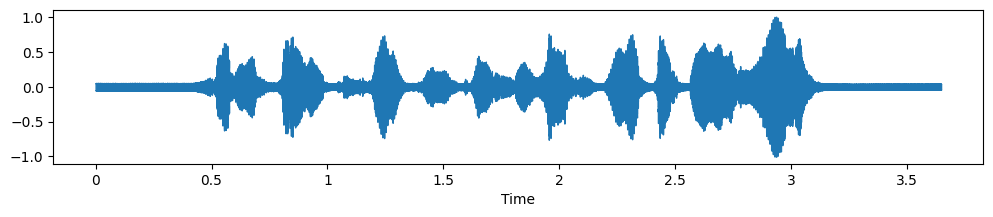

In [21]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 2))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

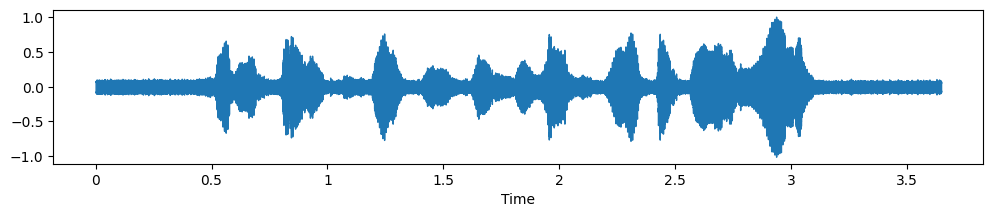

In [22]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,2))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

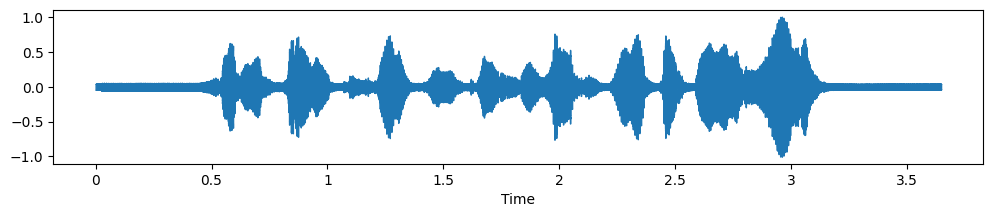

In [23]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,2))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

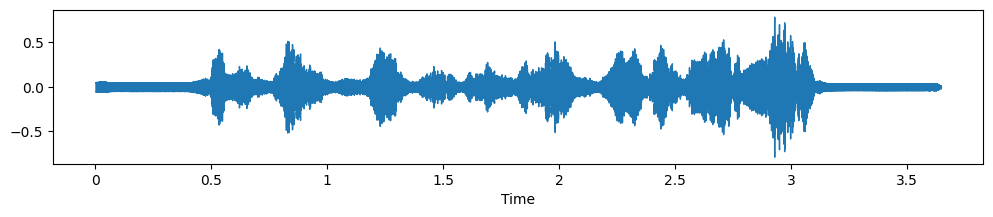

In [24]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 2))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [25]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)


def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


In [26]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


# Normal way to get features

In [27]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

3it [00:00,  8.26it/s]

0 audio has been processed


503it [00:33, 14.02it/s]

500 audio has been processed


1003it [01:11, 12.79it/s]

1000 audio has been processed


1504it [01:49, 16.85it/s]

1500 audio has been processed


2002it [02:24, 14.45it/s]

2000 audio has been processed


2503it [02:57, 16.15it/s]

2500 audio has been processed


3003it [03:37, 15.73it/s]

3000 audio has been processed


3504it [04:10, 17.44it/s]

3500 audio has been processed


4003it [04:41, 16.26it/s]

4000 audio has been processed


4502it [05:13, 13.83it/s]

4500 audio has been processed


5002it [05:46, 14.63it/s]

5000 audio has been processed


5503it [06:20, 15.62it/s]

5500 audio has been processed


6002it [06:52, 13.29it/s]

6000 audio has been processed


6503it [07:26, 16.46it/s]

6500 audio has been processed


7004it [08:03, 14.06it/s]

7000 audio has been processed


7503it [08:39, 14.27it/s]

7500 audio has been processed


8002it [09:14, 15.54it/s]

8000 audio has been processed


8504it [09:48, 15.63it/s]

8500 audio has been processed


9004it [10:23, 19.27it/s]

9000 audio has been processed


9503it [10:51, 19.83it/s]

9500 audio has been processed


10002it [11:19, 14.56it/s]

10000 audio has been processed


10503it [11:51, 15.29it/s]

10500 audio has been processed


11004it [12:21, 18.02it/s]

11000 audio has been processed


11504it [12:56, 15.27it/s]

11500 audio has been processed


12002it [13:32, 13.20it/s]

12000 audio has been processed


12162it [13:44, 14.75it/s]

Done
Time:  824.6857732999997


In [28]:
len(X), len(Y), data_path.Path.shape

(48648, 48648, (12162,))

In [29]:
import numpy as np

X_stored = np.array(X, dtype=object)
Y_stored = np.array(Y, dtype=object)

np.save("X.npy", X_stored)
np.save("Y.npy", Y_stored)


# Saving features

In [30]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.816714,0.812341,0.807019,0.800742,0.793534,0.785372,0.776301,0.766315,0.755441,neutral
1,0.230957,0.360352,0.483398,0.502441,0.507324,0.495605,0.501953,0.501465,0.502441,0.516113,...,0.973484,-1.839404,-0.489600,0.109726,4.890043,7.365103,2.650235,2.126742,-0.294181,neutral
2,0.256348,0.354492,0.471191,0.414062,0.378418,0.373535,0.354492,0.408691,0.466797,0.522461,...,0.007222,0.007180,0.007128,0.007062,0.006994,0.006906,0.006816,0.006713,0.006601,neutral
3,0.253906,0.375977,0.499512,0.496094,0.487305,0.491699,0.499512,0.502441,0.507812,0.518555,...,6.056975,-2.878431,-5.157751,-6.551688,-0.234089,2.816491,2.040162,-0.093194,-4.412679,neutral
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [31]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.816714,0.812341,0.807019,0.800742,0.793534,0.785372,0.776301,0.766315,0.755441,neutral
1,0.230957,0.360352,0.483398,0.502441,0.507324,0.495605,0.501953,0.501465,0.502441,0.516113,...,0.973484,-1.839404,-0.489600,0.109726,4.890043,7.365103,2.650235,2.126742,-0.294181,neutral
2,0.256348,0.354492,0.471191,0.414062,0.378418,0.373535,0.354492,0.408691,0.466797,0.522461,...,0.007222,0.007180,0.007128,0.007062,0.006994,0.006906,0.006816,0.006713,0.006601,neutral
3,0.253906,0.375977,0.499512,0.496094,0.487305,0.491699,0.499512,0.502441,0.507812,0.518555,...,6.056975,-2.878431,-5.157751,-6.551688,-0.234089,2.816491,2.040162,-0.093194,-4.412679,neutral
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [32]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
1616         True
1617         True
1618         True
1619         True
Emotions    False
Length: 1621, dtype: bool


In [33]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
1616        False
1617        False
1618        False
1619        False
Emotions    False
Length: 1621, dtype: bool


(48648, 1621)

In [34]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
1616        0
1617        0
1618        0
1619        0
Emotions    0
Length: 1621, dtype: int64

# Data preparation

In [35]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [36]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [37]:
print(Y.shape)
X.shape

(48648, 8)


(48648, 1620)

In [38]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 1620), (38918, 8), (9730, 1620), (9730, 8))

In [39]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [40]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 1620), (38918, 8), (9730, 1620), (9730, 8))

> Applying early stopping for all models


In [41]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_checkpoint = ModelCheckpoint(
    'best_model1_weights.h5', monitor='val_accuracy', save_best_only=True
)

early_stop = EarlyStopping(
    monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True
)

lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=1e-5, mode='max'
)


In [42]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 1620, 1), (38918, 8), (9730, 1620, 1), (9730, 8))

In [45]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(8,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 1620, 512)           │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1620, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 810, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 810, 512)            │       1,311,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 810, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 405, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 405, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 405, 256)            │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 405, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 203, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 203, 256)            │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 203, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 102, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 102, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 102, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 102, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 51, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 51, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6528)                │              

 Total params: 5,620,872 (21.44 MB)

 Trainable params: 5,616,520 (21.43 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [46]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
351/609 ━━━━━━━━━━━━━━━━━━━━ 22:51 5s/step - accuracy: 0.3633 - loss: 1.8566

KeyboardInterrupt: 

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")